This notebook trains a model to mimic the behavior of the COMPAS recidivism classifier. The specific binary classification task for this model is to determine if a person belongs in the "Low" risk class according to COMPAS (negative class), or the "Medium" or "High" risk class (positive class).

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.15.0


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from imblearn.under_sampling import RandomUnderSampler
import pickle

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
# Read data
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [ ]:
#@title Preprocess the data

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race'])

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Female', 'sex_Male', 'age', 'race_African-American', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
#input_features = ['income_Lower', 'income_Higher', 'age', 'social-class_SC1', 'social-class_SC2', 'social-class_SC3', 'social-class_SC4', 'social-class_Other', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,recidivism_within_2_years,COMPASS_determination,sex_Female,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,69,0,0,0,0,0,0,0,1,0,0,0,0,1
1,34,0,0,0,0,1,0,0,1,1,0,0,0,0
2,24,0,0,1,4,1,0,0,1,1,0,0,0,0
3,23,0,1,0,1,0,1,0,1,1,0,0,0,0
4,43,0,0,0,2,0,0,0,1,0,0,0,0,1


In [ ]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

In [ ]:
#@title Regression model
# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2600      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13951 (54.50 KB)
Trainable params: 13951 (54.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(train_data.values, train_labels.values, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
163/163 [==============================] - 2s 4ms/step - loss: 0.1847 - val_loss: 0.1658
Epoch 2/10
163/163 [==============================] - 1s 3ms/step - loss: 0.1736 - val_loss: 0.1622
Epoch 3/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1734 - val_loss: 0.1623
Epoch 4/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1751 - val_loss: 0.1699
Epoch 5/10
163/163 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.1626
Epoch 6/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1729 - val_loss: 0.1689
Epoch 7/10
163/163 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.1606
Epoch 8/10
163/163 [==============================] - 1s 3ms/step - loss: 0.1712 - val_loss: 0.1697
Epoch 9/10
163/163 [==============================] - 1s 3ms/step - loss: 0.1699 - val_loss: 0.1633
Epoch 10/10
163/163 [==============================] - 1s 3ms/step - loss: 0.1690 - val_loss: 0.1598

In [ ]:
# Predict on the validation set
predictions = model.predict(test_data.values)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_labels.values, predictions)

# Calculate Mean Squared Error
mse = mean_squared_error(test_labels.values, predictions)

# Calculate R^2 score
r2 = r2_score(test_labels.values, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

46/46 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.3400367973972569
Mean Squared Error: 0.17672059420720865
R^2 Score: 0.2899089547338609


In [ ]:
#@title Binary Classification model
# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile the model with binary_crossentropy loss and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               2600      
                                                                 
 dense_5 (Dense)             (None, 50)                10050     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13951 (54.50 KB)
Trainable params: 13951 (54.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(train_data.values, train_labels.values, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
163/163 [==============================] - 2s 5ms/step - loss: 0.5506 - accuracy: 0.7175 - val_loss: 0.5725 - val_accuracy: 0.6799
Epoch 2/10
163/163 [==============================] - 1s 3ms/step - loss: 0.5227 - accuracy: 0.7387 - val_loss: 0.4928 - val_accuracy: 0.7578
Epoch 3/10
163/163 [==============================] - 1s 3ms/step - loss: 0.5145 - accuracy: 0.7437 - val_loss: 0.4994 - val_accuracy: 0.7561
Epoch 4/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5186 - accuracy: 0.7395 - val_loss: 0.4891 - val_accuracy: 0.7699
Epoch 5/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5083 - accuracy: 0.7479 - val_loss: 0.5114 - val_accuracy: 0.7353
Epoch 6/10
163/163 [==============================] - 1s 4ms/step - loss: 0.5111 - accuracy: 0.7398 - val_loss: 0.4881 - val_accuracy: 0.7647
Epoch 7/10
163/163 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.7448 - val_loss: 0.4858 - val_accuracy: 0.7612
Epoch 

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data.values, test_labels.values)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for test data
test_predictions = model.predict(test_data.values)
test_predictions_rounded = test_predictions.round()

# Calculate precision and recall
precision = precision_score(test_labels.values, test_predictions_rounded)
recall = recall_score(test_labels.values, test_predictions_rounded)

print("Test Precision:", precision)
print("Test Recall:", recall)

# Calculate train metrics
train_predictions = model.predict(train_data.values)
train_predictions_rounded = train_predictions.round()

train_accuracy = accuracy_score(train_labels.values, train_predictions_rounded)
train_precision = precision_score(train_labels.values, train_predictions_rounded)
train_recall = recall_score(train_labels.values, train_predictions_rounded)

print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)

46/46 [==============================] - 0s 2ms/step - loss: 0.5208 - accuracy: 0.7297
Test Loss: 0.5207697749137878
Test Accuracy: 0.7297297120094299
46/46 [==============================] - 0s 2ms/step
Test Precision: 0.6968011126564673
Test Recall: 0.7444279346210996
181/181 [==============================] - 0s 2ms/step
Train Accuracy: 0.7527291630566626
Train Precision: 0.7216757741347906
Train Recall: 0.7492435703479576


##Final Dummy Model

This is a better model with following improvements:
  * More features added
  * K-Fold cross validation used

As a result, this is a better mimic of the 'COMPAS' algorithm.

In [ ]:
#@title Preprocess the data

# Read data
df = pd.read_csv('compas-scores-two-years.csv')

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
#df = df[df['decile_score'] != -1]
df = df[df['days_b_screening_arrest'].notnull()]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race'])
df['duration'] = df['end'] - df['start']

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Female', 'sex_Male', 'age', 'race_African-American', 'race_Caucasian',
                  'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count',
                  'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest','c_days_from_compas', 'duration']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head(20)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,recidivism_within_2_years,COMPASS_determination,sex_Female,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other,duration
0,69,0,0,0,0,-1.0,1.0,0,0,0,1,0,0,0,0,1,327
1,34,0,0,0,0,-1.0,1.0,1,0,0,1,1,0,0,0,0,150
2,24,0,0,1,4,-1.0,1.0,1,0,0,1,1,0,0,0,0,63
5,44,0,0,0,0,0.0,0.0,0,0,0,1,0,0,0,0,1,852
6,41,0,0,0,14,-1.0,1.0,1,1,0,1,0,1,0,0,0,35
7,43,0,0,0,3,-1.0,1.0,0,0,0,1,0,0,0,0,1,265
8,39,0,0,0,0,-1.0,1.0,0,0,1,0,0,1,0,0,0,745
9,21,0,0,0,1,428.0,308.0,1,0,0,1,0,1,0,0,0,428
10,27,0,0,0,0,-1.0,1.0,0,0,0,1,0,1,0,0,0,857
11,23,0,0,0,3,0.0,0.0,1,1,0,1,1,0,0,0,0,124


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907 entries, 0 to 7213
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        6907 non-null   int64  
 1   juv_fel_count              6907 non-null   int64  
 2   juv_misd_count             6907 non-null   int64  
 3   juv_other_count            6907 non-null   int64  
 4   priors_count               6907 non-null   int64  
 5   days_b_screening_arrest    6907 non-null   float64
 6   c_days_from_compas         6907 non-null   float64
 7   recidivism_within_2_years  6907 non-null   int64  
 8   COMPASS_determination      6907 non-null   int64  
 9   sex_Female                 6907 non-null   uint8  
 10  sex_Male                   6907 non-null   uint8  
 11  race_African-American      6907 non-null   uint8  
 12  race_Caucasian             6907 non-null   uint8  
 13  race_Hispanic              6907 non-null   uint8

In [ ]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

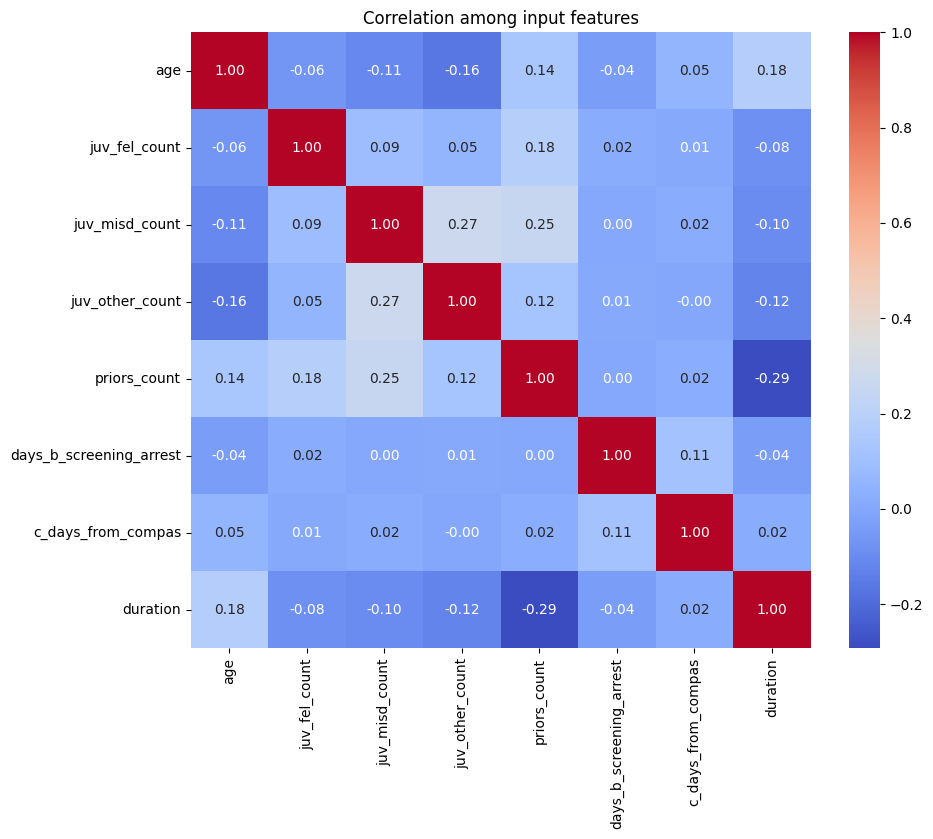

In [ ]:
#@title Analyze data before training
numeric_df = train_data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()

# corrplot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation among input features')
plt.show()

0    3733
1    3174
Name: COMPASS_determination, dtype: int64


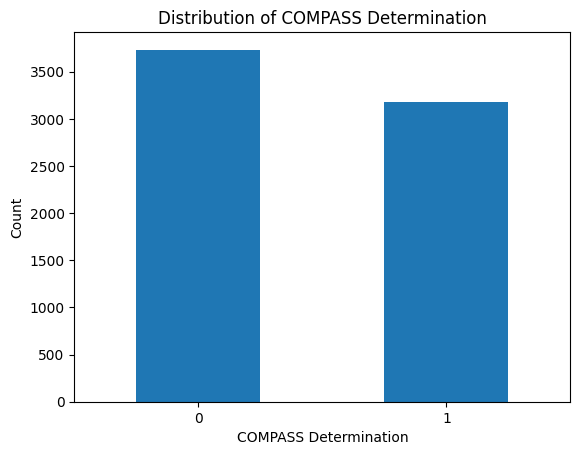

In [ ]:
#is it balanced?
#target_var = df['recidivism_within_2_years'].value_counts()
target_var = df['COMPASS_determination'].value_counts()
print(target_var)

target_var.plot(kind='bar')
#plt.title('Distribution of True Recid')
plt.title('Distribution of COMPASS Determination')
plt.xlabel('COMPASS Determination')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [ ]:
# # Define the undersampling strategy
# undersampler = RandomUnderSampler(random_state=42)

# # Perform undersampling
# train_data, train_labels = undersampler.fit_resample(train_data, train_labels)

# # Print the class distribution after undersampling
# print("Class distribution after undersampling:")
# print(pd.Series(train_labels).value_counts())

Class distribution after undersampling:
0    2527
1    2527
Name: COMPASS_determination, dtype: int64


In [ ]:
#@title K-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store evaluation metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
conf_matrices = []

# This is the size of the array we'll be feeding into our model for each example
input_size = len(train_data.iloc[0])

# Create and compile the model
model = Sequential()
model.add(Dense(200, input_shape=(input_size,), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Perform K-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
for train_index, val_index in skf.split(train_data, train_labels):
    X_train_fold, X_val_fold = train_data.iloc[train_index], train_data.iloc[val_index]
    y_train_fold, y_val_fold = train_labels.iloc[train_index], train_labels.iloc[val_index]

    # Train the model
    history = model.fit(X_train_fold.values, y_train_fold.values, epochs=12, batch_size=32, validation_data=(X_val_fold.values, y_val_fold.values))

    # Extract training and validation loss and accuracy from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Append the values to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_data.values, test_labels.values)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Predict labels for test data
    test_predictions = model.predict(test_data.values)
    test_predictions_rounded = test_predictions.round()

    # Calculate precision and recall
    precision = precision_score(test_labels.values, test_predictions_rounded)
    recall = recall_score(test_labels.values, test_predictions_rounded)
    test_precisions.append(precision)
    test_recalls.append(recall)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_labels.values, test_predictions_rounded)
    conf_matrices.append(conf_matrix)

# Calculate average training and validation loss and accuracy across all folds
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)
avg_train_acc = np.mean(train_accuracies, axis=0)
avg_val_acc = np.mean(val_accuracies, axis=0)

# Calculate average evaluation metrics across all folds
avg_test_loss = sum(test_losses) / num_folds
avg_test_accuracy = sum(test_accuracies) / num_folds
avg_test_precision = sum(test_precisions) / num_folds
avg_test_recall = sum(test_recalls) / num_folds


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               3200      
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 14551 (56.84 KB)
Trainable params: 14551 (56.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/12
139/139 [==============================] - 2s 4ms/step - loss: 1.0889 - accuracy: 0.6208 - val_loss: 0.6992 - val_accuracy: 0.6986
Epoch 2/12

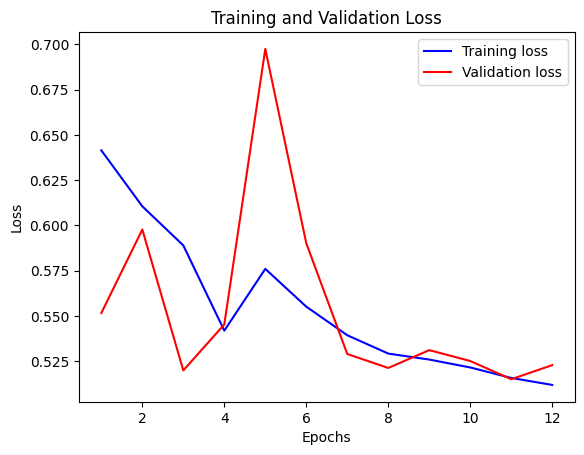

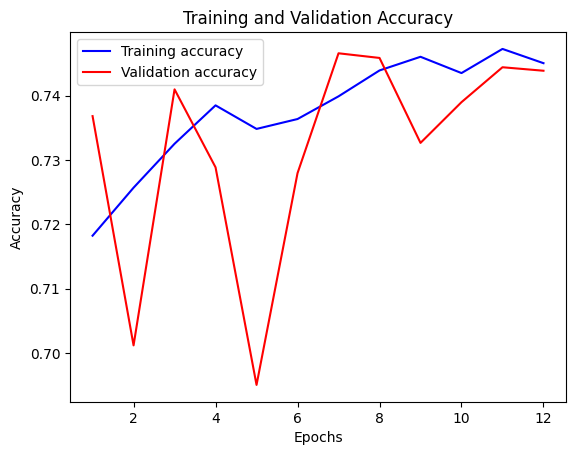

In [ ]:
# Plot learning curve
epochs = range(1, len(avg_train_loss) + 1)
plt.plot(epochs, avg_train_loss, 'b', label='Training loss')
plt.plot(epochs, avg_val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, avg_train_acc, 'b', label='Training accuracy')
plt.plot(epochs, avg_val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Test metrics
print("Average Training Loss:", sum(avg_train_loss)/epochs)
print("Average Validation Loss:", sum(avg_val_loss)/epochs)
print("Average Test Loss:", avg_test_loss)
print('\n')
print("Average Training Accuracy:", sum(avg_train_acc)/epochs)
print("Average Validation Accuracy:", sum(avg_val_acc)/epochs)
print("Average Test Accuracy:", avg_test_accuracy)
print('\n')
print("Average Test Precision:", avg_test_precision)
print("Average Test Recall:", avg_test_recall)

Average Training Loss: 0.5548664217193923
Average Validation Loss: 0.5539366205533346
Average Test Loss: 0.5616855621337891


Average Training Accuracy: 0.7376659125089646
Average Validation Accuracy: 0.7319457173347472
Average Test Accuracy: 0.725759756565094


Average Test Precision: 0.7537664412343745
Average Test Recall: 0.6160741885625965


Average Confusion Matrix:
[[604 130]
 [248 398]]


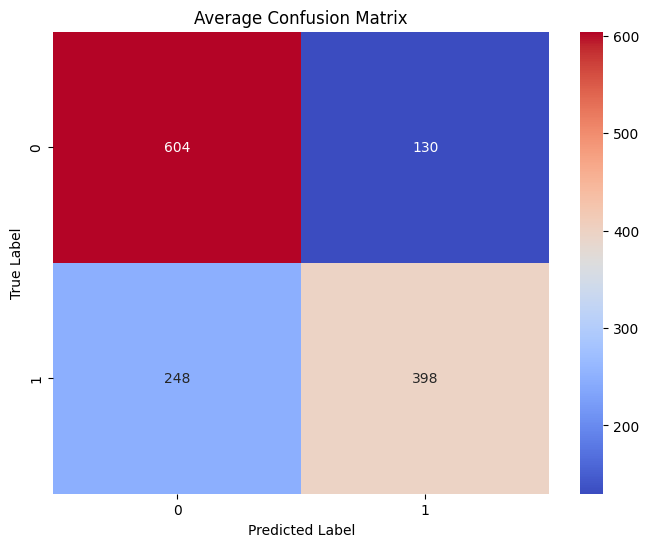

In [ ]:
# Calculate and print average confusion matrix
avg_conf_matrix = sum(conf_matrices) // num_folds
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Plot average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()